In [1]:
# General Libraries
import matplotlib.pyplot as plt
%matplotlib widget
import torch
import numpy as np
import torch.nn as nn

import pandas as pd

import importlib

synchron_ad = importlib.import_module('synchron_ad')
utilities = importlib.import_module('utilities')
synchronization_utils = importlib.import_module('synchronization_heads.synchronization_utils')



WIDTH = 11
HEIGHT = 3

In [2]:
PARAMS ={
    "prefix":"FMCE",
    "model":"FMCE",
    "device": "mps",
    "seed": 1995,
    "batch_size": 128,
    "epochs": 10,
    "lr": 1e-4,
    "patience": 10,
    "valid_size": 0.1,
    "normalisation": "std_window",
    "machine": "BrushlessMotor",
    "sensors": ["imp23absu_mic", "ism330dhcx_acc", "ism330dhcx_gyro"],
    "synchronization_method": "sync_head_conv",  # "sync_head_conv", "sync_head_fc", "resample_linear", "resample_fft", "zeropad", "resample_spline"
    "desynchronization_method": "conv",  # "conv", "fc"
    "C_sync": 1,
    "C_fuse": 4,
    "kernel_size": 3,
    "fc_num_layers": 3,
    "pre_train_sync": True,
    "post_train_sync": False,
    "lambda": 0.5,
}

train_data_loader, valid_data_loader, test_data_loader, Y_test, NUM_CHANNELS, WINDOW_LENGTHS = utilities.initialise_dataloaders(PARAMS)

In [3]:
synchron_ad.train_model(PARAMS, train_data_loader, valid_data_loader, test_data_loader, Y_test, NUM_CHANNELS, WINDOW_LENGTHS)

Skipping ism330dhcx_gyro as it has the same window length as another
Optimum window length: 790, corresponding lambda: 0.40610006854009595
For sensor imp23absu_mic there are 1102 solutions
For sensor ism330dhcx_acc there are 1 solutions
For sensor ism330dhcx_gyro there are 1 solutions

----------- Epoch 1 -----------


Valid Epoch 1: 100%|██████████| 52/52 [00:00<00:00, 127.42it/s, Valid_loss=0.706]



----------- Epoch 2 -----------


Valid Epoch 2: 100%|██████████| 52/52 [00:00<00:00, 156.82it/s, Valid_loss=0.509]



----------- Epoch 3 -----------


Valid Epoch 3: 100%|██████████| 52/52 [00:00<00:00, 166.35it/s, Valid_loss=0.366]



----------- Epoch 4 -----------


Valid Epoch 4: 100%|██████████| 52/52 [00:00<00:00, 167.14it/s, Valid_loss=0.281]



----------- Epoch 5 -----------


Valid Epoch 5: 100%|██████████| 52/52 [00:00<00:00, 158.45it/s, Valid_loss=0.216]



----------- Epoch 6 -----------


Valid Epoch 6: 100%|██████████| 52/52 [00:00<00:00, 157.75it/s, Valid_loss=0.163]



----------- Epoch 7 -----------


Valid Epoch 7: 100%|██████████| 52/52 [00:00<00:00, 158.92it/s, Valid_loss=0.13] 



----------- Epoch 8 -----------


Valid Epoch 8: 100%|██████████| 52/52 [00:00<00:00, 147.16it/s, Valid_loss=0.107]



----------- Epoch 9 -----------


Valid Epoch 9: 100%|██████████| 52/52 [00:00<00:00, 152.61it/s, Valid_loss=0.0914]



----------- Epoch 10 -----------


Valid Epoch 10: 100%|██████████| 52/52 [00:00<00:00, 156.82it/s, Valid_loss=0.0784]


Loaded best model from epoch 10 with val_loss = 0.0784


Predicting: 100%|██████████| 125/125 [00:01<00:00, 69.88it/s]


PARAMS have been written to experiments/FMCE-BrushlessMotor-sync_head_conv-True-False-0.5/PARAMS.json


In [4]:
experiment_name = 'FMCE-BrushlessMotor-sync_head_conv-True-False-0.5'
# Define your paths
synchronisation_block_path = f"experiments/{experiment_name}/synchronisation_block.pth"
desynchronisation_block_path = f"experiments/{experiment_name}/desynchronisation_block.pth"
fusing_block_path = f"experiments/{experiment_name}/fusing_block.pth"

# 1. Initialize parameters for the sync head convolution
sync_head_conv_parameters = synchronization_utils.initialize_parameters(
    SENSORS=PARAMS["sensors"],
    WINDOW_LENGTHS=PARAMS['WINDOW_LENGTHS'],
    NUM_CHANNELS=PARAMS['NUM_CHANNELS'],
    lambda_=PARAMS['lambda']
)

# 2. Build the model blocks
builder = synchron_ad.ModelBuilder(PARAMS, sync_head_conv_parameters)
synchronisation_block, desynchronisation_block, fusing_block = builder.build_all_blocks()

# 3. Load the pre-trained weights from disk
#    If you need to load on a particular device, use map_location=torch.device('cpu') or similar.
if PARAMS['post_train_sync'] == True:
    synchronisation_block.load_state_dict(
        torch.load(synchronisation_block_path, map_location=torch.device(PARAMS['device']))
    )
    desynchronisation_block.load_state_dict(
        torch.load(desynchronisation_block_path, map_location=torch.device(PARAMS['device']))
    )

fusing_block.load_state_dict(
    torch.load(fusing_block_path, map_location=torch.device(PARAMS['device']))
)
trainer = synchron_ad.FusionTrainer(
    synchronisation_block=synchronisation_block,
    fusing_block=fusing_block,
    desynchronisation_block=desynchronisation_block,
    train_sync=PARAMS['post_train_sync'],
    epochs=PARAMS['epochs'],
    patience=PARAMS['patience'],
    lr=PARAMS['lr'],
    device=PARAMS['device'],
)
synched_outputs, fused_outputs = trainer.predict(test_data_loader)

Skipping ism330dhcx_gyro as it has the same window length as another
Optimum window length: 790, corresponding lambda: 0.40610006854009595
For sensor imp23absu_mic there are 1102 solutions
For sensor ism330dhcx_acc there are 1 solutions
For sensor ism330dhcx_gyro there are 1 solutions


Predicting: 100%|██████████| 125/125 [00:01<00:00, 66.16it/s]


# Reconstruction Visualization

Sensor: imp23absu_mic, Losses on channels: 0.865
Sensor: ism330dhcx_acc, Losses on channels: 0.041, 0.103, 0.089
Sensor: ism330dhcx_gyro, Losses on channels: 0.303, 0.090, 0.163


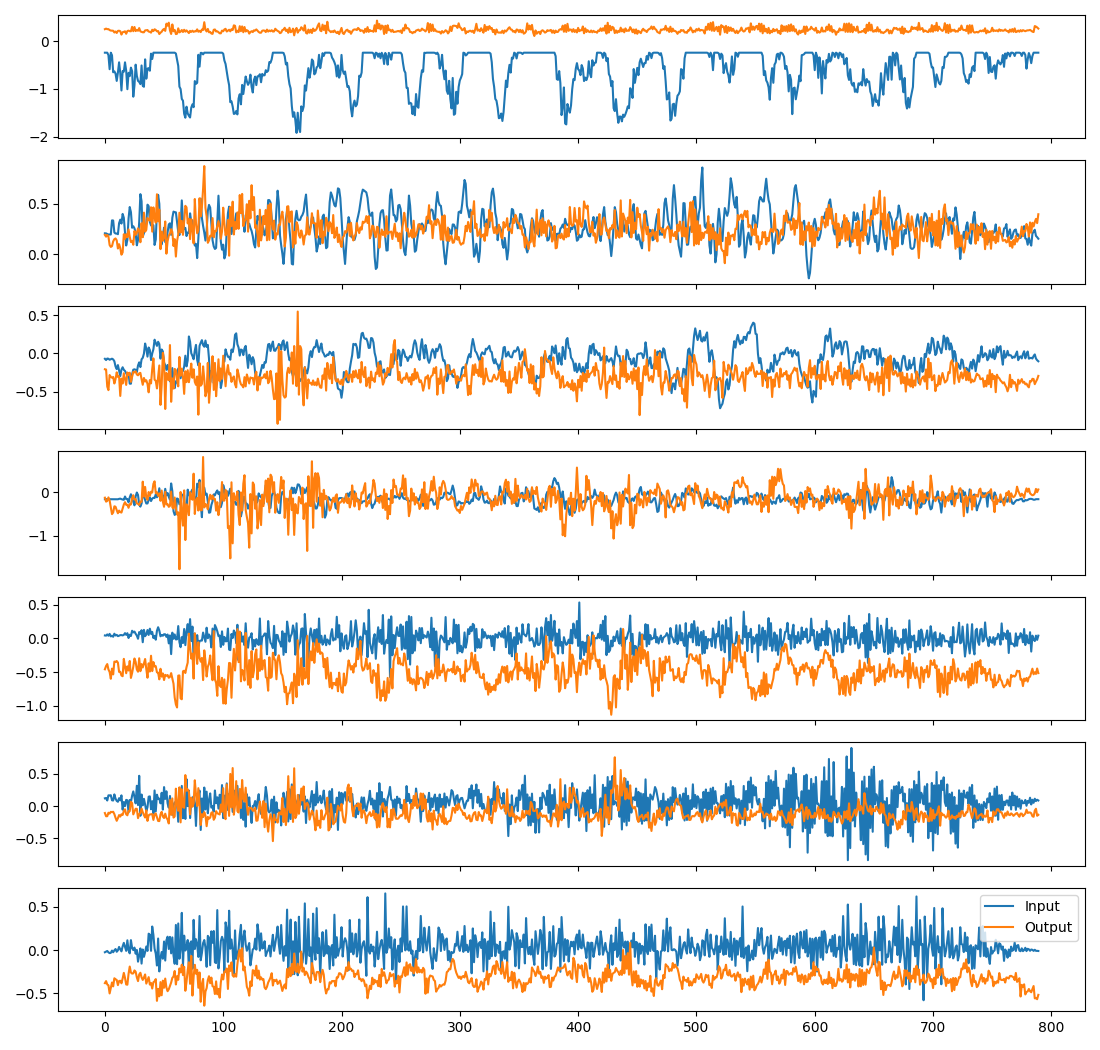

In [6]:
sample = np.random.randint(0, len(test_data_loader.dataset))

total_plot = sum([NUM_CHANNELS[sensor] for sensor in PARAMS["sensors"]])
plt.close('all')
fig, axs = plt.subplots(total_plot, 1, figsize=(
    WIDTH, HEIGHT * total_plot * 0.5), sharex=True)

i = 0
overall_MSE = 0
for sensor_idx, sensor in enumerate(PARAMS["sensors"]):
    sensor_losses = []
    for channel_idx in range(NUM_CHANNELS[sensor]):
        if PARAMS['post_train_sync']:
            input = synched_outputs[sensor_idx][sample,channel_idx].cpu().numpy()
            output = fused_outputs[sensor_idx][sample,channel_idx].detach().cpu().numpy()

            # Calculate loss on output
            loss_output = ((input - output)**2).mean(0)
            sensor_losses.append(f"{loss_output:.3f}")

            t = np.linspace(0, 1, len(input))

            axs[i].plot(t,input, label='Input')
            axs[i].plot(t,output, label='Output')

        
        else:
            input = synched_outputs[sample][i].cpu().numpy()
            output = fused_outputs[sample][i].detach().cpu().numpy()

            # Calculate loss on output
            loss_output = ((input - output)**2).mean(0)
            sensor_losses.append(f"{loss_output:.3f}")

            axs[i].plot(input, label='Input')
            axs[i].plot(output, label='Output')
        i += 1
        overall_MSE += loss_output
    print(f"Sensor: {sensor}, Losses on channels: {', '.join(sensor_losses)}")

plt.legend()
plt.tight_layout()

# Test interpolation methods here

In [ ]:
# Define interpolation methods
spline_interp = SynchronizationBlock(
    sensors=PARAMS["sensors"],
    window_lengths=WINDOW_LENGTHS,
    num_channels=NUM_CHANNELS,
    c_sync=16,
    synchronization_method='resample_spline',
    fc_num_layers=1,
    sync_head_conv_parameters=sync_head_conv_parameters,
    params=PARAMS
)

linear_interp = SynchronizationBlock(
    sensors=PARAMS["sensors"],
    window_lengths=WINDOW_LENGTHS,
    num_channels=NUM_CHANNELS,
    c_sync=16,
    synchronization_method='resample_linear',
    fc_num_layers=1,
    sync_head_conv_parameters=sync_head_conv_parameters,
    params=PARAMS
)

# Select a random sample from the validation dataset
sample_idx = np.random.randint(0, len(valid_data_loader.dataset))
X_sample = valid_data_loader.dataset[sample_idx:sample_idx+1]

# Apply interpolation methods
X_spline = spline_interp(X_sample)
X_linear = linear_interp(X_sample)

# Plot the results
total_channels = sum(NUM_CHANNELS.values())
plt.close('all')
fig, axs = plt.subplots(total_channels, 1, figsize=(WIDTH, HEIGHT * total_channels * 0.5), sharex=True)

i = 0
for sensor_idx, sensor in enumerate(PARAMS["sensors"]):
    for channel_idx in range(NUM_CHANNELS[sensor]):
        t_input = np.linspace(0, 1, WINDOW_LENGTHS[sensor])
        input_data = X_sample[sensor_idx][0, channel_idx].cpu().numpy()

        t_spline = np.linspace(0, 1, X_spline[0][i].shape[0])
        output_spline = X_spline[0][i].detach().cpu().numpy()

        t_linear = np.linspace(0, 1, X_linear[0][i].shape[0])
        output_linear = X_linear[0][i].detach().cpu().numpy()

        axs[i].plot(t_input, input_data, label='Input')
        axs[i].plot(t_spline, output_spline, label='Output Spline')
        axs[i].plot(t_linear, output_linear, label='Output Linear')
        i += 1

plt.legend()
plt.tight_layout()
plt.show()
